In [1]:
import torch
from reconstruction import AE
from datasets import MeshData
from utils import DataLoader
import tqdm
import numpy as np
import geomloss
from pytorch3d.loss import chamfer_distance
from scipy.stats import entropy
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor
from numpy.linalg import norm
from sklearn.metrics import accuracy_score, mean_squared_error

/home/jakaria/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [94]:
device = torch.device('cuda', 1)
# Set the path to the saved model directory
#model_path = "/home/jakaria/torus_bump_500_three_scale_binary_bump_variable_noise_fixed_angle/models_classification_regression_only_correlation_loss/models/65"
#model_path = "/home/jakaria/Explaining_Shape_Variability/src/DeepLearning/compute_canada/guided_vae/data/CoMA/raw/torus/models_contrastive_inhib/253"
#model_path = "/home/jakaria/Explaining_Shape_Variability/src/DeepLearning/compute_canada/guided_vae/data/CoMA/raw/torus/models_guided/30"# Load the saved model
#model_path = "/home/jakaria/Explaining_Shape_Variability/src/DeepLearning/compute_canada/guided_vae/data/CoMA/raw/torus/models_attribute/23"
#model_path = "/home/jakaria/Explaining_Shape_Variability/src/DeepLearning/compute_canada/guided_vae/data/CoMA/raw/hippocampus/models_guided/44"
#model_path = "/home/jakaria/Explaining_Shape_Variability/src/DeepLearning/compute_canada/guided_vae/data/CoMA/raw/hippocampus/models_contrastive_inhib/172"
#model_path = "/home/jakaria/Explaining_Shape_Variability/src/DeepLearning/compute_canada/guided_vae/data/CoMA/raw/hippocampus/models_attribute/99"
model_path = "/home/jakaria/Explaining_Shape_Variability/src/DeepLearning/compute_canada/guided_vae/data/CoMA/raw/torus/models_only_bvae/10"

model_state_dict = torch.load(f"{model_path}/model_state_dict.pt")
in_channels = torch.load(f"{model_path}/in_channels.pt")
out_channels = torch.load(f"{model_path}/out_channels.pt")
latent_channels = torch.load(f"{model_path}/latent_channels.pt")
spiral_indices_list = torch.load(f"{model_path}/spiral_indices_list.pt")
up_transform_list = torch.load(f"{model_path}/up_transform_list.pt")
down_transform_list = torch.load(f"{model_path}/down_transform_list.pt")
std = torch.load(f"{model_path}/std.pt")
mean = torch.load(f"{model_path}/mean.pt")
template_face = torch.load(f"{model_path}/faces.pt")

# Create an instance of the model
model = AE(in_channels, out_channels, latent_channels,
           spiral_indices_list, down_transform_list,
           up_transform_list)
model.load_state_dict(model_state_dict)
model.to(device)
# Set the model to evaluation mode
model.eval()

AE(
  (en_layers): ModuleList(
    (0): SpiralEnblock(
      (conv): SpiralConv(3, 8, seq_length=9)
    )
    (1): SpiralEnblock(
      (conv): SpiralConv(8, 8, seq_length=9)
    )
    (2): SpiralEnblock(
      (conv): SpiralConv(8, 8, seq_length=9)
    )
    (3): SpiralEnblock(
      (conv): SpiralConv(8, 16, seq_length=9)
    )
    (4): Linear(in_features=1568, out_features=24, bias=True)
  )
  (de_layers): ModuleList(
    (0): Linear(in_features=12, out_features=1568, bias=True)
    (1): SpiralDeblock(
      (conv): SpiralConv(16, 16, seq_length=9)
    )
    (2): SpiralDeblock(
      (conv): SpiralConv(16, 8, seq_length=9)
    )
    (3): SpiralDeblock(
      (conv): SpiralConv(8, 8, seq_length=9)
    )
    (4): SpiralDeblock(
      (conv): SpiralConv(8, 8, seq_length=9)
    )
    (5): SpiralConv(8, 3, seq_length=9)
  )
  (cls_sq): Sequential(
    (0): Linear(in_features=1, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [95]:
template_fp = "/home/jakaria/Explaining_Shape_Variability/src/DeepLearning/compute_canada/guided_vae/data/CoMA/template/template.ply"
data_fp = "/home/jakaria/Explaining_Shape_Variability/src/DeepLearning/compute_canada/guided_vae/data/CoMA"
test_exp = "bareteeth"
split = "interpolation"

meshdata = MeshData(data_fp,
                    template_fp,
                    split=split,
                    test_exp=test_exp)

train_loader = DataLoader(meshdata.train_dataset, batch_size=16)
test_loader = DataLoader(meshdata.test_dataset, batch_size=16)

angles_train = []
thick_train = []
latent_codes_train = []

angles_test = []
thick_test = []
latent_codes_test = []

test_original = []
test_reconstructed = []
latents_list = []

single_latent = False
#print(type(train_loader))

with torch.no_grad():
    for i, data in enumerate(train_loader):
        #print("train...")
        x = data.x.to(device)
        y = data.y.to(device)
        pred, mu, log_var, re, re2 = model(x)

        z = model.reparameterize(mu, log_var)
        if single_latent:
            z = z[:,1]
        latent_codes_train.append(z)
        angles_train.append(y[:, :, 1])
        thick_train.append(y[:, :, 0])

with torch.no_grad():
    for i, data in enumerate(test_loader):
        #print("test...")
        x = data.x.to(device)
        y = data.y.to(device)
        pred, mu, log_var, re, re2 = model(x)

        z = model.reparameterize(mu, log_var)
        if single_latent:
            z = z[:,1]
        latent_codes_test.append(z)
        latents_list.append(z)
        angles_test.append(y[:, :, 1])
        thick_test.append(y[:, :, 0])

        test_original.append(x)
        test_reconstructed.append(pred)

latent_codes_train = torch.cat(latent_codes_train)
if single_latent:
    latent_codes_train = latent_codes_train.cpu().numpy().reshape(-1, 1)
else:
    latent_codes_train = latent_codes_train.cpu().numpy()
angles_train = torch.cat(angles_train).view(-1,1)
angles_train = angles_train.view(-1).cpu().numpy()
thick_train = torch.cat(thick_train).view(-1,1)
thick_train = thick_train.view(-1).cpu().numpy()

latent_codes_test = torch.cat(latent_codes_test)
if single_latent:
    latent_codes_test = latent_codes_test.cpu().numpy().reshape(-1, 1)
else:   
    latent_codes_test = latent_codes_test.cpu().numpy()
angles_test = torch.cat(angles_test).view(-1,1)
angles_test = angles_test.view(-1).cpu().numpy()
thick_test = torch.cat(thick_test).view(-1,1)
thick_test = thick_test.view(-1).cpu().numpy()

# latent statistics
latents = torch.cat(latents_list, dim=0)
z_means = torch.mean(latents, dim=0)
z_stds = torch.std(latents, dim=0)
z_mins, _ = torch.min(latents, dim=0)
z_maxs, _ = torch.max(latents, dim=0)
z_stats = {'means': z_means, 'stds': z_stds,
            'mins': z_mins, 'maxs': z_maxs}

test_original = torch.cat(test_original)
#test_original = test_original.cpu().numpy()
test_reconstructed = torch.cat(test_reconstructed)
#test_reconstructed = test_reconstructed.cpu().numpy()

# Train a classifier on the latent codes
X_train = latent_codes_train
y_train = thick_train
X_test = latent_codes_test
y_test = thick_test

#knn = KNeighborsClassifier(n_neighbors=5)
knn = KNeighborsRegressor(n_neighbors=12)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
#print(y_test[:10], y_pred[:10])
#print(latent_codes_test[:10], y_test[:10])

#print(y_test, y_pred)
#print("Accuracy of the KNN for binary bump: ", accuracy_score(y_test, y_pred[:len(y_test)]))
print("MSE of the KNN for thickness: ", mean_squared_error(y_test, y_pred[:len(y_test)]))
print(latent_codes_train.shape, latent_codes_test.shape)

/home/jakaria/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/home/jakaria/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `

Normalizing...
Done!
MSE of the KNN for thickness:  0.009722223
(4000, 12) (500, 12)


In [7]:
LR = LinearRegression()
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)
print("MSE of the Linear Regression for thickness: ", mean_squared_error(y_test, y_pred[:len(y_test)]))

MSE of the Linear Regression for thickness:  0.0017567916


In [97]:
def get_random_sample(n_samples=32, latent_channels=16):
    # Combine the arrays
    combined_latent_codes = np.concatenate((latent_codes_train, latent_codes_test), axis=0)

    # Initialize an array to store the sampled values
    sampled_values_all = np.zeros((n_samples, latent_channels))

    for i in range(n_samples):
        # Sample each dimension separately
        for j in range(latent_channels):
            # Extract the values for the current dimension
            current_dimension_values = combined_latent_codes[:, j]

            # Calculate the CDF for the current dimension
            hist, bins = np.histogram(current_dimension_values, bins=50)
            bin_midpoints = bins[:-1] + np.diff(bins) / 2
            cdf = np.cumsum(hist)
            cdf = cdf / cdf[-1]

            # Generate a random value
            random_value = np.random.rand()

            # Use np.searchsorted to find the bin index corresponding to the random value
            bin_index = np.searchsorted(cdf, random_value)

            # Map the bin index to the corresponding value
            sampled_value = bin_midpoints[bin_index]

            # Assign the sampled value to the result array
            sampled_values_all[i, j] = sampled_value

    print(sampled_values_all.shape)
    return sampled_values_all

In [66]:
print("Random sample: ", get_random_sample())

IndexError: index 12 is out of bounds for axis 1 with size 12

In [98]:
test_original_small = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        #print("test...")
        x = data.x.to(device)
        y = data.y.to(device)

        test_original_small.append(x)
        
        if i == 1:
            print(len(test_original_small))
            break
test_original_small = torch.cat(test_original_small)
print(test_original_small.shape)

2
torch.Size([32, 3496, 3])


In [99]:
def random_latent(n_samples, latent_dim=12):
    z = torch.randn([n_samples, latent_dim])
    z = z.to(device)
    return z

In [100]:
def random_generation(n_samples=32, latent_dim=12):
    #z = random_latent(n_samples, latent_dim=latent_dim)
    z = get_random_sample(n_samples, latent_channels=latent_dim)
    z = torch.from_numpy(z).float()
    with torch.no_grad():
        gen_verts = model.decoder(z.to(device))
    return gen_verts

In [101]:
def emd_approx(sample, ref):
    return geomloss.SamplesLoss()(sample, ref)


def _pairwise_emd_cd_(sample_pcs, ref_pcs, batch_size):
    print("computing Earth Mover and Chamfer distances")
    n_sample = sample_pcs.shape[0]
    n_ref = ref_pcs.shape[0]
    all_cd = []
    all_emd = []
    iterator = range(n_sample)
    for sample_b_start in tqdm.tqdm(iterator):
        sample_batch = sample_pcs[sample_b_start]

        cd_lst = []
        emd_lst = []
        for ref_b_start in range(0, n_ref, batch_size):
            ref_b_end = min(n_ref, ref_b_start + batch_size)
            ref_batch = ref_pcs[ref_b_start:ref_b_end]

            batch_size_ref = ref_batch.size(0)
            sample_batch_exp = sample_batch.view(1, -1, 3).expand(
                batch_size_ref, -1, -1)
            sample_batch_exp = sample_batch_exp.contiguous()

            cd_lst.append(chamfer_distance(sample_batch_exp, ref_batch,
                          batch_reduction=None)[0].unsqueeze(0))

            emd_batch = emd_approx(sample_batch_exp, ref_batch)
            emd_lst.append(emd_batch.view(1, -1))

        cd_lst = torch.cat(cd_lst, dim=-1)
        emd_lst = torch.cat(emd_lst, dim=-1)
        all_cd.append(cd_lst)
        all_emd.append(emd_lst)

    all_cd = torch.cat(all_cd, dim=0)  # n_sample, n_ref
    all_emd = torch.cat(all_emd, dim=0)  # n_sample, n_ref
    return all_cd, all_emd


def knn(m_xx, m_xy, m_yy, k, sqrt=False):
    n0 = m_xx.size(0)
    n1 = m_yy.size(0)
    label = torch.cat((torch.ones(n0), torch.zeros(n1))).to(m_xx)
    mat = torch.cat((torch.cat((m_xx, m_xy), 1),
                    torch.cat((m_xy.transpose(0, 1), m_yy), 1)), 0)
    if sqrt:
        mat = mat.abs().sqrt()

    val, idx = (mat + torch.diag(
        float('inf') * torch.ones(n0 + n1).to(m_xx))).topk(k, 0, False)

    count = torch.zeros(n0 + n1).to(m_xx)
    for i in range(0, k):
        count = count + label.index_select(0, idx[i])
    pred = torch.ge(count, (float(k) / 2) *
                    torch.ones(n0 + n1).to(m_xx)).float()

    s = {
        'tp': (pred * label).sum(),
        'fp': (pred * (1 - label)).sum(),
        'fn': ((1 - pred) * label).sum(),
        'tn': ((1 - pred) * (1 - label)).sum(),
    }

    s.update({
        'precision': s['tp'] / (s['tp'] + s['fp'] + 1e-10),
        'recall': s['tp'] / (s['tp'] + s['fn'] + 1e-10),
        'acc_t': s['tp'] / (s['tp'] + s['fn'] + 1e-10),
        'acc_f': s['tn'] / (s['tn'] + s['fp'] + 1e-10),
        'acc': torch.eq(label, pred).float().mean(),
    })
    return s


def lgan_mmd_cov(all_dist):
    n_sample, n_ref = all_dist.size(0), all_dist.size(1)
    min_val_fromsmp, min_idx = torch.min(all_dist, dim=1)
    min_val, _ = torch.min(all_dist, dim=0)
    mmd = min_val.mean()
    mmd_smp = min_val_fromsmp.mean()
    cov = float(min_idx.unique().view(-1).size(0)) / float(n_ref)
    cov = torch.tensor(cov).to(all_dist)
    return {
        'lgan_mmd': mmd,
        'lgan_cov': cov,
        'lgan_mmd_smp': mmd_smp,
    }


def compute_all_metrics(sample_pcs, ref_pcs, batch_size):
    results = {}

    m_rs_cd, m_rs_emd = _pairwise_emd_cd_(sample_pcs, ref_pcs, batch_size)
    '''
    res_cd = lgan_mmd_cov(m_rs_cd.t())
    results.update({
        "%s-CD" % k: v for k, v in res_cd.items()
    })

    res_emd = lgan_mmd_cov(m_rs_emd.t())
    results.update({
        "%s-EMD" % k: v for k, v in res_emd.items()
    })
    '''
    m_rr_cd, m_rr_emd = _pairwise_emd_cd_(ref_pcs, ref_pcs, batch_size)
    m_ss_cd, m_ss_emd = _pairwise_emd_cd_(sample_pcs, sample_pcs, batch_size)
    
    # 1-NN results
    one_nn_cd_res = knn(m_rr_cd, m_rs_cd, m_ss_cd, 1, sqrt=False)
    results.update({
        "1-NN-CD-%s" % k: v for k, v in one_nn_cd_res.items() if 'acc' in k
    })
    one_nn_emd_res = knn(m_rr_emd, m_rs_emd, m_ss_emd, 1, sqrt=False)
    results.update({
        "1-NN-EMD-%s" % k: v for k, v in one_nn_emd_res.items() if 'acc' in k
    })

    return results


In [102]:
random_generation = random_generation(n_samples=32, latent_dim=12)
print(random_generation.shape)

(32, 12)
torch.Size([32, 3496, 3])


In [54]:
# contrastive
restults = compute_all_metrics(random_generation, test_original_small, 16)
print(restults)

computing Earth Mover and Chamfer distances


100%|██████████| 32/32 [00:45<00:00,  1.42s/it]


computing Earth Mover and Chamfer distances


100%|██████████| 32/32 [00:46<00:00,  1.44s/it]


computing Earth Mover and Chamfer distances


100%|██████████| 32/32 [00:46<00:00,  1.44s/it]


{'1-NN-CD-acc_t': tensor(0.3125, device='cuda:1'), '1-NN-CD-acc_f': tensor(0.7188, device='cuda:1'), '1-NN-CD-acc': tensor(0.5156, device='cuda:1'), '1-NN-EMD-acc_t': tensor(0.3750, device='cuda:1'), '1-NN-EMD-acc_f': tensor(0.6875, device='cuda:1'), '1-NN-EMD-acc': tensor(0.5312, device='cuda:1')}


In [72]:
# guided
restults = compute_all_metrics(random_generation, test_original_small, 16)
print(restults)

computing Earth Mover and Chamfer distances


100%|██████████| 32/32 [00:45<00:00,  1.42s/it]


computing Earth Mover and Chamfer distances


100%|██████████| 32/32 [00:46<00:00,  1.44s/it]


computing Earth Mover and Chamfer distances


100%|██████████| 32/32 [00:42<00:00,  1.33s/it]


{'1-NN-CD-acc_t': tensor(0.0938, device='cuda:1'), '1-NN-CD-acc_f': tensor(0.9375, device='cuda:1'), '1-NN-CD-acc': tensor(0.5156, device='cuda:1'), '1-NN-EMD-acc_t': tensor(0.1562, device='cuda:1'), '1-NN-EMD-acc_f': tensor(1., device='cuda:1'), '1-NN-EMD-acc': tensor(0.5781, device='cuda:1')}


In [92]:
# attribute
restults = compute_all_metrics(random_generation, test_original_small, 16)
print(restults)

computing Earth Mover and Chamfer distances


100%|██████████| 32/32 [00:45<00:00,  1.42s/it]


computing Earth Mover and Chamfer distances


100%|██████████| 32/32 [00:46<00:00,  1.44s/it]


computing Earth Mover and Chamfer distances


100%|██████████| 32/32 [00:46<00:00,  1.44s/it]


{'1-NN-CD-acc_t': tensor(0.5000, device='cuda:1'), '1-NN-CD-acc_f': tensor(0.6875, device='cuda:1'), '1-NN-CD-acc': tensor(0.5938, device='cuda:1'), '1-NN-EMD-acc_t': tensor(0.5625, device='cuda:1'), '1-NN-EMD-acc_f': tensor(0.5938, device='cuda:1'), '1-NN-EMD-acc': tensor(0.5781, device='cuda:1')}


In [103]:
# bvae
restults = compute_all_metrics(random_generation, test_original_small, 16)
print(restults)

computing Earth Mover and Chamfer distances


100%|██████████| 32/32 [00:45<00:00,  1.42s/it]


computing Earth Mover and Chamfer distances


100%|██████████| 32/32 [00:46<00:00,  1.44s/it]


computing Earth Mover and Chamfer distances


100%|██████████| 32/32 [00:46<00:00,  1.44s/it]


{'1-NN-CD-acc_t': tensor(0.4375, device='cuda:1'), '1-NN-CD-acc_f': tensor(0.5938, device='cuda:1'), '1-NN-CD-acc': tensor(0.5156, device='cuda:1'), '1-NN-EMD-acc_t': tensor(0.5938, device='cuda:1'), '1-NN-EMD-acc_f': tensor(0.5312, device='cuda:1'), '1-NN-EMD-acc': tensor(0.5625, device='cuda:1')}


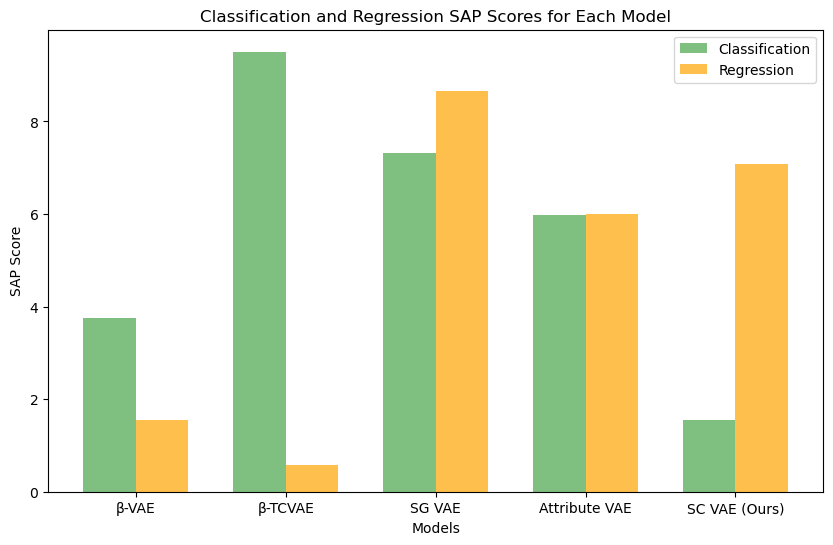

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Generating random values for each model
np.random.seed(42)  # Setting seed for reproducibility
models = ['\u03B2-VAE', '\u03B2-TCVAE', 'SG VAE', 'Attribute VAE', 'SC VAE (Ours)']
values1 = [0.13, 0.11, 0.23, 0.325 ,0.399]  # Random values between 0 and 10
values2 = [0.36, 0.37, 0.855, 0.963, 0.96]  # Random values between 0 and 10

# Creating a bar plot
bar_width = 0.35
index = np.arange(len(models))

plt.figure(figsize=(10, 6))
plt.bar(index, values1, width=bar_width, label='Classification', color='green', alpha=0.5)
plt.bar(index + bar_width, values2, width=bar_width, label='Regression', color='orange', alpha=0.7)

plt.xlabel('Models')
plt.ylabel('SAP Score')
plt.title('Classification and Regression SAP Scores for Each Model')
plt.xticks(index + bar_width / 2, models)
plt.legend()
plt.show()
